# Salesforce BLIP Evaluation: retrieval metrics

This notebook loads the best BLIP checkpoint, computes image and text embeddings on the validation set,
and reports retrieval metrics (Top-1, Top-5, Top-10).

Ensure you run this from the repository root so relative paths match (or update the paths below).

In [1]:
# Configuration
from pathlib import Path
import sys
repo_root = Path('..').resolve()  # adjust if running from a different CWD
sys.path.append(str(repo_root))

CHECKPOINT_PATH = Path('checkpoints_blip/best_blip.pth')
VAL_CSV = Path('../../data/alpaca_mbj_bandgap_test.csv')
TRAIN_CSV = Path('../../data/alpaca_mbj_bandgap_train.csv')
BATCH_SIZE = 32
DEVICE = 'cuda' if __import__('torch').cuda.is_available() else 'cpu'
print(f'Using device: {DEVICE}, checkpoint: {CHECKPOINT_PATH}')

Using device: cuda, checkpoint: checkpoints_blip/best_blip.pth


In [2]:
# Setup matplotlib for Jupyter notebook
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Set matplotlib backend
matplotlib.use('Agg')  # Use Anti-Grain Geometry backend
plt.ioff()  # Turn off interactive mode

print("Matplotlib setup complete")

Matplotlib setup complete


In [3]:
# Imports and model/dataset loading
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pandas as pd
from tqdm.auto import tqdm

from transformers import AutoProcessor
from PIL import Image

# For mixed precision inference
from torch.cuda.amp import autocast

# Import BLIP model and dataset from the training script
from train_blip import BlipForRetrieval, ImageTextDataset

# Initialize model and processor
model_name = "Salesforce/blip-itm-large-coco"
processor = AutoProcessor.from_pretrained(model_name)
model = BlipForRetrieval.from_pretrained(model_name)
device = torch.device(DEVICE)
model.to(device)
model.eval()

# Load checkpoint
assert CHECKPOINT_PATH.exists(), f"Checkpoint not found: {CHECKPOINT_PATH}"
ckpt = torch.load(str(CHECKPOINT_PATH), map_location='cpu')
model.load_state_dict(ckpt['model_state_dict'])
print(f"Loaded checkpoint from epoch {ckpt['epoch']} with val_loss {ckpt['val_loss']:.4f}")

# Load validation data
val_df = pd.read_csv(VAL_CSV)
val_ds = ImageTextDataset(val_df, processor, train=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
print(f'Validation examples: {len(val_ds)}')

/home/jipengsun/.conda/envs/clipp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jipengsun/.conda/envs/clipp/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loaded checkpoint from epoch 33 with val_loss 0.3763
Validation examples: 1000


In [9]:
# Compute embeddings for entire validation set
val_img_embs_list = []
val_txt_embs_list = []
captions = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc='Computing validation embeddings'):
        pixel_values = batch['pixel_values'].to(device)
        texts = batch['caption']
        
        # Process texts through processor
        txts = processor(text=list(texts), padding=True, return_tensors='pt').to(device)
        
        # Use AMP for faster inference
        with autocast():
            img_feats = model.get_image_features(pixel_values)
            txt_feats = model.get_text_features(input_ids=txts['input_ids'], attention_mask=txts['attention_mask'])
        
        val_img_embs_list.append(img_feats.cpu())
        val_txt_embs_list.append(txt_feats.cpu())
        captions.extend(texts)

val_img_embs = torch.cat(val_img_embs_list, dim=0)
val_txt_embs = torch.cat(val_txt_embs_list, dim=0)
print(f'Computed validation embeddings: images {val_img_embs.shape}, texts {val_txt_embs.shape}')

Computing validation embeddings:   0%|          | 0/32 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment vari

Computed validation embeddings: images torch.Size([1000, 256]), texts torch.Size([1000, 256])


In [10]:
# Function to compute both text-to-image and image-to-text retrieval accuracies
def compute_retrieval_metrics(text_embeddings, image_embeddings, k_values=[1, 5, 10]):
    """
    Compute both text-to-image and image-to-text retrieval accuracies.
    
    Args:
        text_embeddings: tensor of shape (N, D) - text embeddings
        image_embeddings: tensor of shape (N, D) - image embeddings  
        k_values: list of k values for top-k accuracy
    
    Returns:
        similarity matrix for further analysis
    """
    # Compute similarity matrix
    scores = text_embeddings @ image_embeddings.T  # (N_text, N_image)
    
    # Text-to-Image Retrieval (text queries retrieving images)
    print("=== TEXT-TO-IMAGE RETRIEVAL ===")
    print("For each text query, find the correct corresponding image")
    
    for k in k_values:
        if k == 1:
            # Top-1: check if argmax equals correct index
            top_k_acc = torch.mean(
                (torch.argmax(scores, dim=1) == torch.arange(scores.shape[0], device=scores.device)).float()
            ).item()
        else:
            # Top-k: check if correct index is in top-k
            top_k_acc = torch.mean(
                torch.tensor([
                    i in torch.topk(scores[i], k).indices.tolist()
                    for i in range(scores.shape[0])
                ], dtype=torch.float32, device=scores.device)
            ).item()
        
        print(f"Text-to-Image Top-{k}: {top_k_acc:.4f}")
    
    # Image-to-Text Retrieval (image queries retrieving texts)  
    print("\n=== IMAGE-TO-TEXT RETRIEVAL ===")
    print("For each image query, find the correct corresponding text")
    
    scores_transposed = scores.T  # (N_image, N_text) - now images are queries
    
    for k in k_values:
        if k == 1:
            # Top-1: check if argmax equals correct index
            top_k_acc = torch.mean(
                (torch.argmax(scores_transposed, dim=1) == torch.arange(scores_transposed.shape[0], device=scores_transposed.device)).float()
            ).item()
        else:
            # Top-k: check if correct index is in top-k
            top_k_acc = torch.mean(
                torch.tensor([
                    i in torch.topk(scores_transposed[i], k).indices.tolist()
                    for i in range(scores_transposed.shape[0])
                ], dtype=torch.float32, device=scores_transposed.device)
            ).item()
        
        print(f"Image-to-Text Top-{k}: {top_k_acc:.4f}")
    
    return scores

# Compute retrieval metrics for validation set
print("VALIDATION SET RESULTS:") 
scores = compute_retrieval_metrics(val_txt_embs, val_img_embs)

VALIDATION SET RESULTS:
=== TEXT-TO-IMAGE RETRIEVAL ===
For each text query, find the correct corresponding image
Text-to-Image Top-1: 0.4680
Text-to-Image Top-5: 0.7290
Text-to-Image Top-10: 0.8090

=== IMAGE-TO-TEXT RETRIEVAL ===
For each image query, find the correct corresponding text
Image-to-Text Top-1: 0.4530
Image-to-Text Top-5: 0.7360
Image-to-Text Top-10: 0.8010


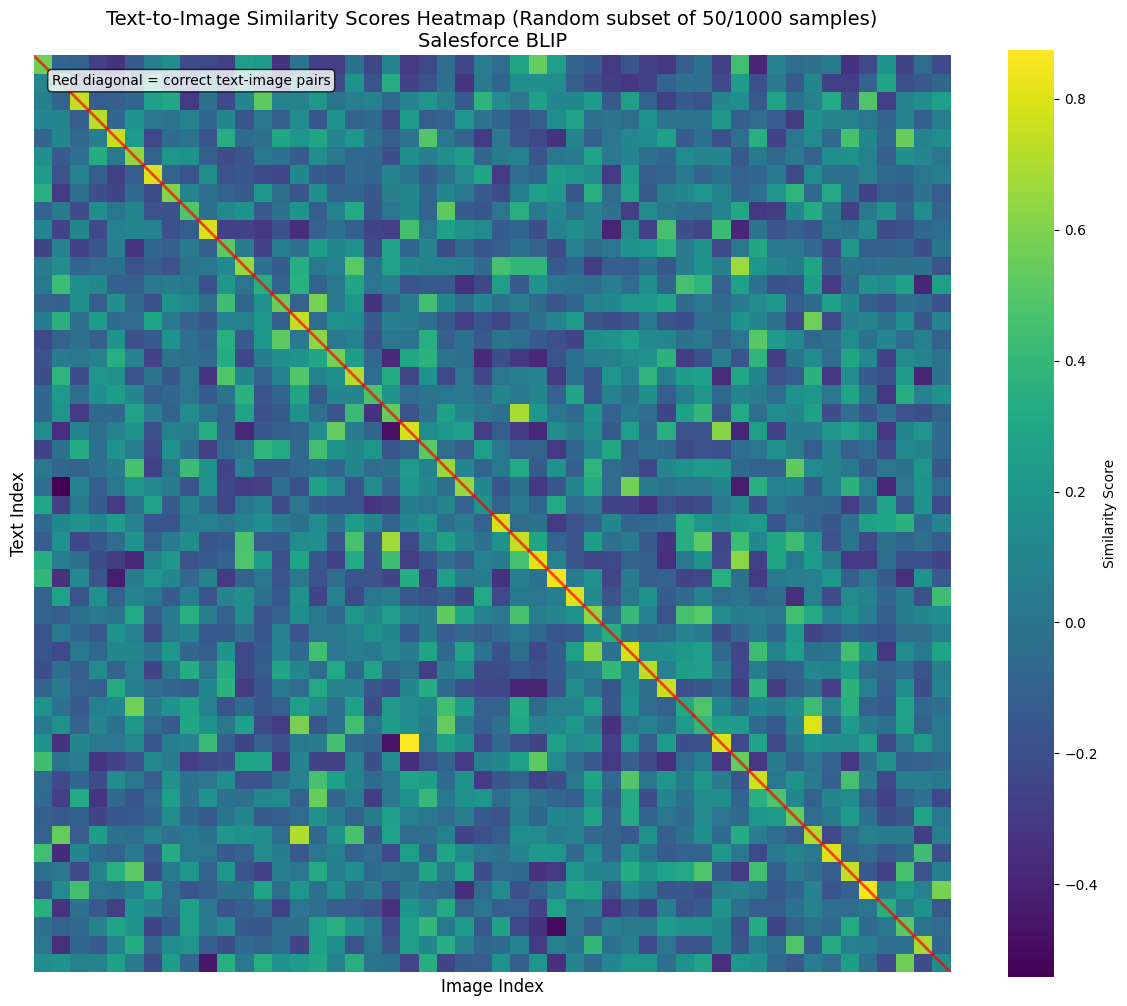

Heatmap shows similarity scores between 50 text queries and 50 images
Perfect retrieval would show a bright diagonal line (high similarity for correct pairs)
Score range: -0.542 to 0.874
Mean diagonal score: 0.616
Mean off-diagonal score: 0.012


<Figure size 640x480 with 0 Axes>

In [7]:
# Create heatmap visualization of similarity scores
import seaborn as sns

# Ensure plots are displayed inline
%matplotlib inline

# For visualization, we'll use a subset if the matrix is too large
max_samples = 50  # Adjust this number based on your preference
n_samples = min(max_samples, scores.shape[0])

# Sample indices for visualization
if scores.shape[0] > max_samples:
    sample_indices = np.random.choice(scores.shape[0], n_samples, replace=False)
    sample_indices = np.sort(sample_indices)  # Keep them sorted for better visualization
    scores_subset = scores[sample_indices][:, sample_indices]
    title_suffix = f" (Random subset of {n_samples}/{scores.shape[0]} samples)"
else:
    scores_subset = scores
    sample_indices = np.arange(scores.shape[0])
    title_suffix = f" (All {scores.shape[0]} samples)"

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(scores_subset.numpy(), 
            cmap='viridis', 
            cbar_kws={'label': 'Similarity Score'},
            square=True,
            xticklabels=False,  # Don't show individual sample labels
            yticklabels=False)

# Highlight the diagonal (correct pairs)
for i in range(len(scores_subset)):
    plt.plot([i, i+1], [i, i+1], 'r-', linewidth=2, alpha=0.7)

plt.title(f'Text-to-Image Similarity Scores Heatmap{title_suffix}\nSalesforce BLIP', fontsize=14)
plt.xlabel('Image Index', fontsize=12)
plt.ylabel('Text Index', fontsize=12)

# Add text annotation about the diagonal
plt.text(0.02, 0.98, 'Red diagonal = correct text-image pairs', 
         transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
         verticalalignment='top', fontsize=10)

plt.tight_layout()
plt.show()  # Show plot first
plt.savefig('salesforce_blip_similarity_heatmap.png', dpi=300, bbox_inches='tight')

print(f"Heatmap shows similarity scores between {n_samples} text queries and {n_samples} images")
print(f"Perfect retrieval would show a bright diagonal line (high similarity for correct pairs)")
print(f"Score range: {scores_subset.min().item():.3f} to {scores_subset.max().item():.3f}")
print(f"Mean diagonal score: {torch.diag(scores_subset).mean().item():.3f}")
print(f"Mean off-diagonal score: {scores_subset[~torch.eye(scores_subset.size(0), dtype=bool)].mean().item():.3f}")

# Training Set Evaluation

Compute retrieval metrics on the training set (both text-to-image and image-to-text).
WARNING: this computes an N x N similarity matrix and can be memory intensive for large datasets.

# Embedding Visualization

Let's visualize how well our Salesforce BLIP model aligns the image and text embeddings in the shared space using t-SNE dimensionality reduction.

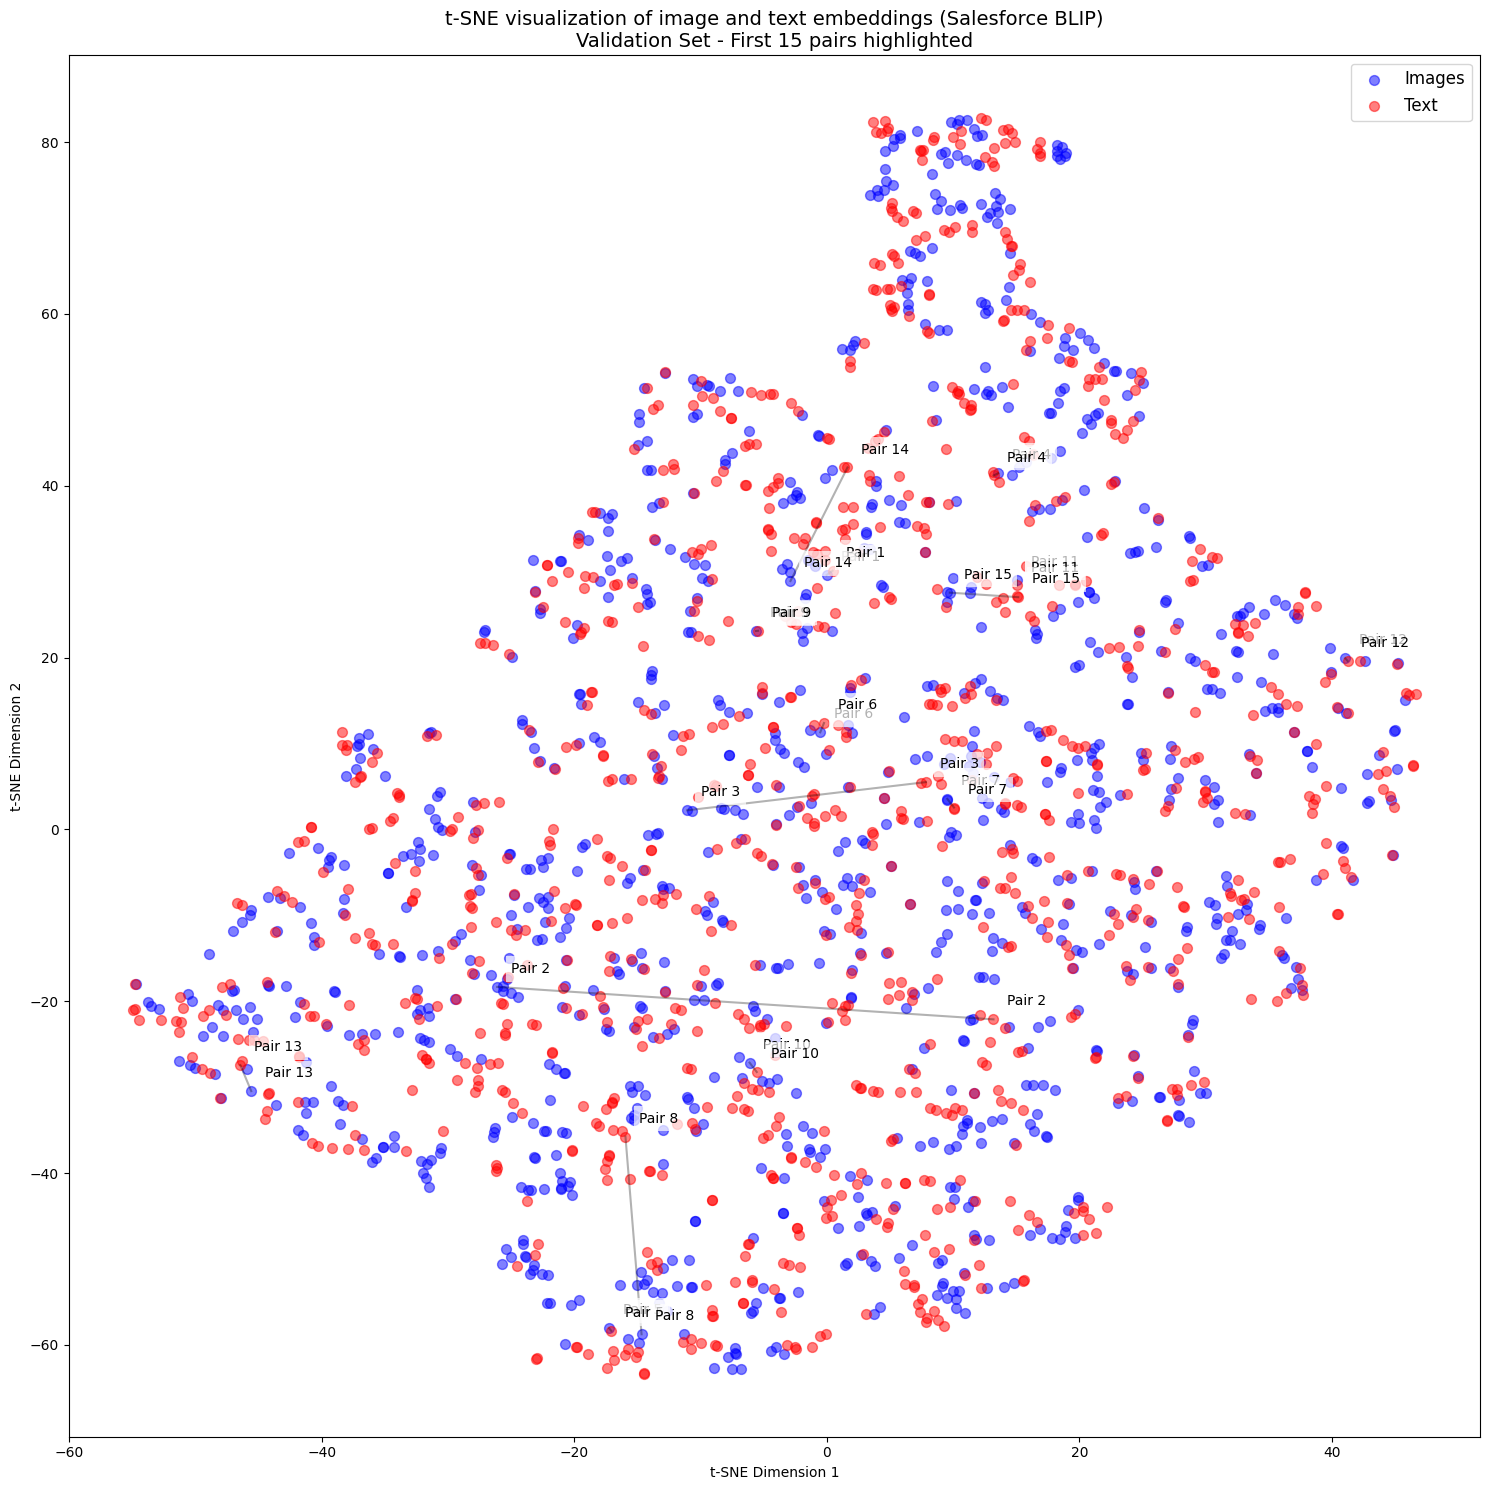

<Figure size 640x480 with 0 Axes>

In [11]:
# t-SNE visualization of embeddings
from sklearn.manifold import TSNE

# Ensure plots are displayed inline
%matplotlib inline

# Combine image and text embeddings
combined_embs = torch.cat([val_img_embs, val_txt_embs], dim=0)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
combined_tsne = tsne.fit_transform(combined_embs.numpy())

# Split back into image and text embeddings
n = len(val_img_embs)
img_tsne = combined_tsne[:n]
txt_tsne = combined_tsne[n:]

# Create visualization
plt.figure(figsize=(15, 15))

# Plot all points
plt.scatter(img_tsne[:, 0], img_tsne[:, 1], c='blue', label='Images', alpha=0.5, s=50)
plt.scatter(txt_tsne[:, 0], txt_tsne[:, 1], c='red', label='Text', alpha=0.5, s=50)

# Draw lines connecting corresponding pairs for the first examples
num_examples = 15  # Number of example pairs to highlight
indices = np.arange(min(num_examples, n))  # Use first 15 examples instead of random

for i, idx in enumerate(indices):
    # Draw a line connecting the image-text pair
    plt.plot([img_tsne[idx, 0], txt_tsne[idx, 0]], 
             [img_tsne[idx, 1], txt_tsne[idx, 1]], 
             'k-', alpha=0.3)
    
    # Add number labels
    plt.annotate(f'Pair {i+1}', 
                xy=(img_tsne[idx, 0], img_tsne[idx, 1]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    plt.annotate(f'Pair {i+1}', 
                xy=(txt_tsne[idx, 0], txt_tsne[idx, 1]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.legend(fontsize=12)
plt.title('t-SNE visualization of image and text embeddings (Salesforce BLIP)\nValidation Set - First 15 pairs highlighted', fontsize=14)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()  # Show plot first
plt.savefig('salesforce_blip_tsne.png', dpi=300, bbox_inches='tight')

In [12]:
# text-to-image accuracy (simple version)
predicted = scores.argmax(dim=1)         # index of the most similar image for each text
correct = torch.arange(len(predicted))   # ground truth (image i should match text i)
accuracy = (predicted == correct).float().mean()
print(f"Text-to-Image Accuracy: {accuracy.item():.4f}")

Text-to-Image Accuracy: 0.4680


# Performance Analysis

Let's analyze the model performance and show some example retrievals.

In [13]:
# Show some example retrievals
print("\n=== Example Retrievals ===")

# Get top-5 retrievals for first 5 text queries
num_examples = 5
for i in range(min(num_examples, len(captions))):
    query_text = captions[i]
    similarities = scores[i]
    top5_indices = torch.topk(similarities, 5).indices.tolist()
    
    print(f"\nQuery {i+1}: {query_text}")
    print(f"Top-5 retrieved images (by similarity):")
    for rank, img_idx in enumerate(top5_indices):
        sim_score = similarities[img_idx].item()
        correct = "✓" if img_idx == i else "✗"
        print(f"  Rank {rank+1}: Image {img_idx} Text: {captions[img_idx]} (similarity: {sim_score:.4f}) {correct}")


=== Example Retrievals ===

Query 1: 1 Li 1 Ge 1 S 0.0
Top-5 retrieved images (by similarity):
  Rank 1: Image 0 Text: 1 Li 1 Ge 1 S 0.0 (similarity: 0.7329) ✓
  Rank 2: Image 375 Text: 1 Ge 2 P 0.0 (similarity: 0.6716) ✗
  Rank 3: Image 941 Text: 1 Mg 1 Fe 1 S 0.0 (similarity: 0.6459) ✗
  Rank 4: Image 708 Text: 1 Na 1 Zn 0.0 (similarity: 0.6406) ✗
  Rank 5: Image 742 Text: 1 Na 1 Pd 1 H 0.0 (similarity: 0.6290) ✗

Query 2: 1 Pr 1 Te 1 Cl 0.88
Top-5 retrieved images (by similarity):
  Rank 1: Image 52 Text: 1 In 2 Sb 4 S 1 Br 2.22 (similarity: 0.6745) ✗
  Rank 2: Image 163 Text: 1 K 1 Sm 2 Te 1.882 (similarity: 0.6242) ✗
  Rank 3: Image 43 Text: 1 Ce 2 S 0.04 (similarity: 0.6079) ✗
  Rank 4: Image 526 Text: 2 Li 2 Pr 3 Si 0.0 (similarity: 0.5569) ✗
  Rank 5: Image 218 Text: 2 K 1 Pt 6 I 1.264 (similarity: 0.5478) ✗

Query 3: 1 Fe 4 Sb 12 O 0.0
Top-5 retrieved images (by similarity):
  Rank 1: Image 2 Text: 1 Fe 4 Sb 12 O 0.0 (similarity: 0.5923) ✓
  Rank 2: Image 260 Text: 2 Pr 2 Sn 